<a href="https://colab.research.google.com/github/andervies/divic-corp-machine-learning-course/blob/main/assignment30/Unet_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem One: Learning / Estimation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import keras
import os


from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
# Import plot_model from the correct module in TensorFlow 2.0+
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

<ipython-input-8-3427b3f9d463>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [ ]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [ ]:
!unzip ./drive/MyDrive/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/d80ead8703.png   
  inflating: images/b012e9ebb0.png   
  inflating: images/d3034e7a60.png   
  inflating: images/ae2ef70d51.png   
  inflating: images/1af44a9db0.png   
  inflating: images/41cfd4b320.png   
  inflating: images/853e89d0d3.png   
  inflating: images/2a484baa26.png   
  inflating: images/92e617896e.png   
  inflating: images/b70f0ab0c2.png   
  inflating: images/e8757626a1.png   
  inflating: images/6a3d92ce59.png   
  inflating: images/127ef4105f.png   
  inflating: images/d21012f5c1.png   
  inflating: images/1cb9549d2c.png   
  inflating: images/e030bdae65.png   
  inflating: images/0cf7155eb6.png   
  inflating: images/badb3ea766.png   
  inflating: images/9bd58061d6.png   
  inflating: images/2b1e71c2a3.png   
  inflating: images/28d42de29f.png   
  inflating: images/10833853b3.png   
  inflating: images/ef13247eed.png   
  inflating: images/bce104494c.png   
  inflating: images/c8ce151a18.png   

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/train/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../content/drive/MyDrive/train/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [ ]:
train_df["images"] = [
    np.array(load_img("/content/drive/MyDrive/train/images/{}.png".format(idx), grayscale=True)) / 255
    if os.path.exists("/content/drive/MyDrive/train/images/{}.png".format(idx))
    else None # Handle the case where the file doesn't exist
    for idx in tqdm_notebook(train_df.index)
]

<ipython-input-30-19d78551f80d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(train_df.index)


  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
train_df["masks"] = [
    np.array(load_img("/content/drive/MyDrive/train/masks/{}.png".format(idx), grayscale=True)) / 255
    if os.path.exists("/content/drive/MyDrive/train/masks/{}.png".format(idx))
    else None # Handle cases where the file doesn't exist
    for idx in tqdm_notebook(train_df.index)
]

<ipython-input-31-a86053645484>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(train_df.index)


  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [ ]:
def cov_to_class(val):
    for i in range(0, 11):
        if val * 10 <= i :
            return i

train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5, 0, 'Coverage class')

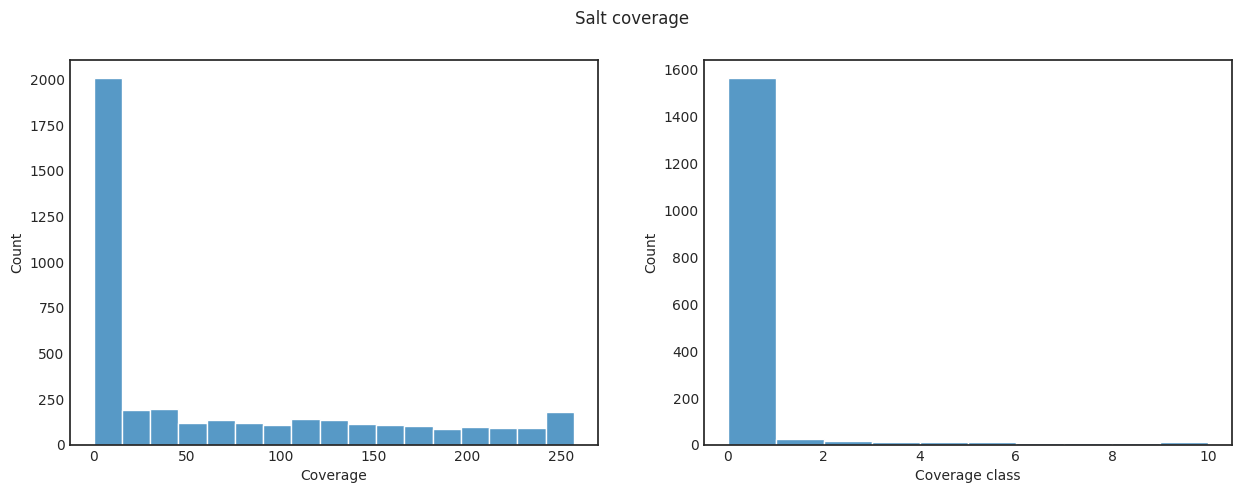

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(train_df.coverage, kde=False, ax=axs[0])
sns.histplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0, 0.5, 'Coverage class')

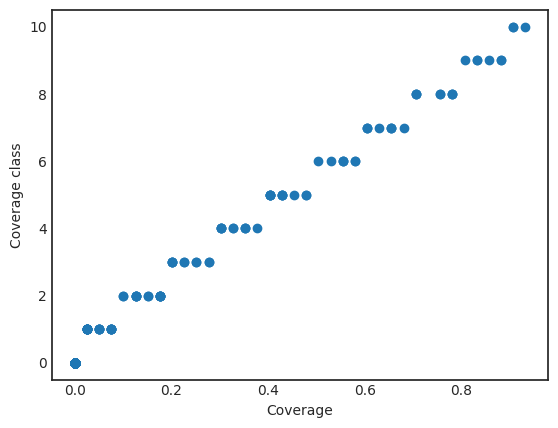

In [ ]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

Text(0.5, 1.0, 'Depth distribution')

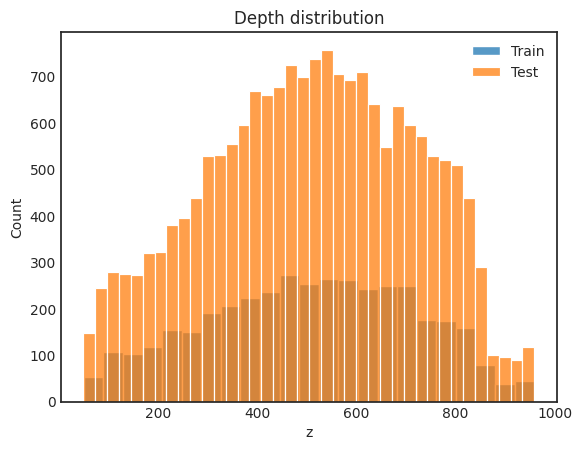

In [ ]:
sns.histplot(train_df.z, label="Train")
sns.histplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

<ipython-input-39-86eef8d76b9e>:30: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


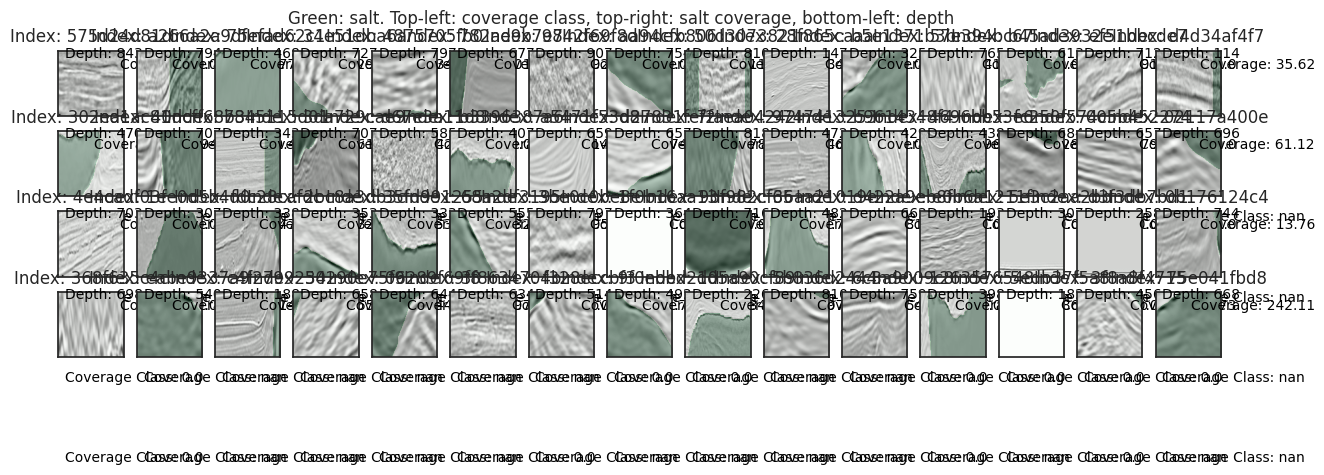

In [ ]:
import matplotlib.pyplot as plt

max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)

# Assuming img_size_ori is defined somewhere
img_size_ori = 256  # Example value, adjust as per your image size

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx, 'images']  # Assuming 'images' is the column name for images
    mask = train_df.loc[idx, 'masks']  # Assuming 'masks' is the column name for masks

    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")

    # Example text positions, adjust as needed
    ax.text(10, 10, f"Depth: {train_df.loc[idx, 'z']}", color="black")
    ax.text(img_size_ori - 10, 10, f"Coverage: {round(train_df.loc[idx, 'coverage'], 2)}", color="black", ha="right", va="top")
    ax.text(10, img_size_ori - 10, f"Coverage Class: {train_df.loc[idx, 'coverage_class']}", color="black", ha="left", va="top")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Index: {idx}")  # Set title as per your requirement

plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
plt.tight_layout()
plt.show()


In [ ]:
def upsample(img):
    if img is None:  # Handle the case where img is None
        return np.zeros((img_size_target, img_size_target), dtype=np.uint8)  # Return a black image or handle as needed
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

# Handle None values in 'coverage_class' before splitting
train_df.coverage_class.fillna(-1, inplace=True)  # Replace None with -1 or any suitable value

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)


In [ ]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [ ]:
model = Model(input_layer, output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5, 0.98, 'Top row: original images, bottom row: augmented images')

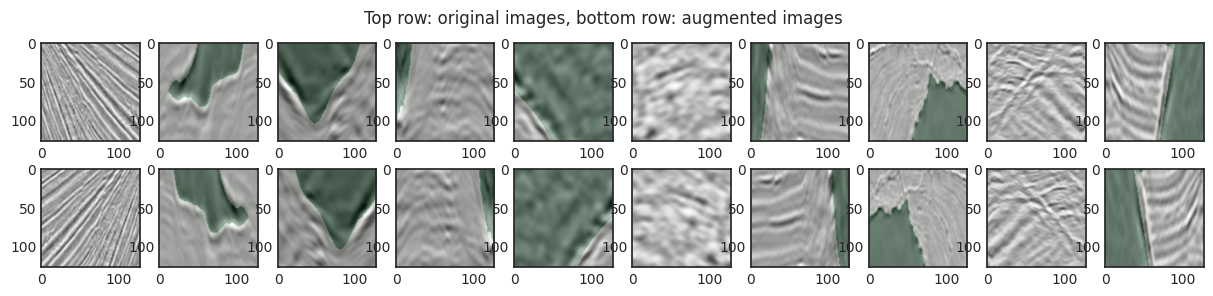

In [ ]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: nan - accuracy: 0.6269
Epoch 1: val_loss did not improve from inf
200/200 [==============================] - 1352s 7s/step - loss: nan - accuracy: 0.6269 - val_loss: nan - val_accuracy: 0.7437 - lr: 0.0010
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: nan - accuracy: 0.7493
Epoch 2: val_loss did not improve from inf
200/200 [==============================] - 1275s 6s/step - loss: nan - accuracy: 0.7493 - val_loss: nan - val_accuracy: 0.7437 - lr: 0.0010
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: nan - accuracy: 0.7493
Epoch 3: val_loss did not improve from inf
200/200 [==============================] - 1275s 6s/step - loss: nan - accuracy: 0.7493 - val_loss: nan - val_accuracy: 0.7437 - lr: 0.0010
Epoch 4/5
200/200 [==============================] - ETA: 0s - loss: nan - accuracy: 0.7493
Epoch 4: val_loss did not improve from inf
200/200 [==============================]

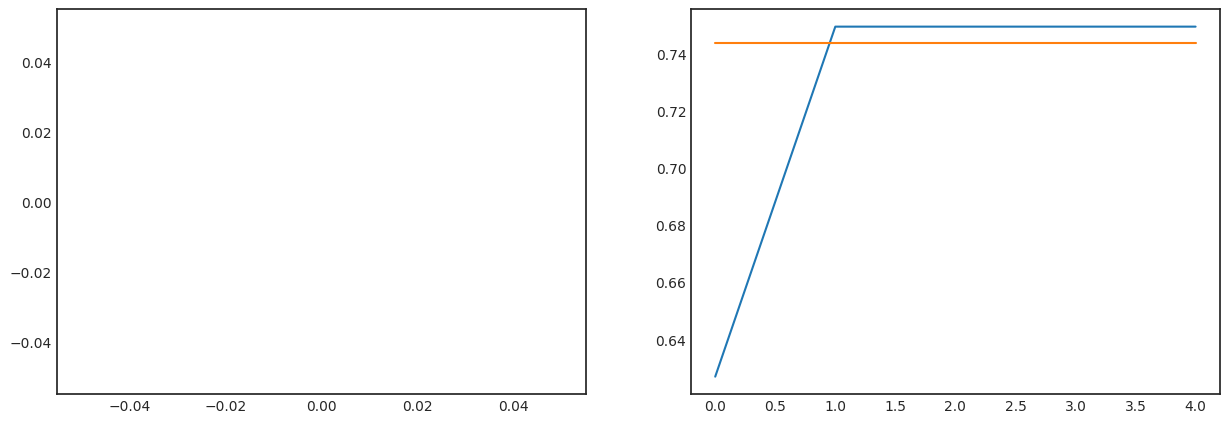

In [47]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 5
batch_size = 32

# Add accuracy to the metrics list when compiling the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Now, retrain the model and plot the results
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid],
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy") # Access accuracy with 'accuracy' key
ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")

In [52]:
model.save("./unet_model.h5")

In [53]:
model.save('unet_model.keras')

In [54]:
model = load_model("unet_model.keras")

In [67]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

25/25 [==============================] - 38s 1s/step


/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:735: RuntimeWarning: All-NaN slice encountered
  and min_func(output_image) <= cval <= max_func(output_image))


<ipython-input-56-84eb32d03fde>:34: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


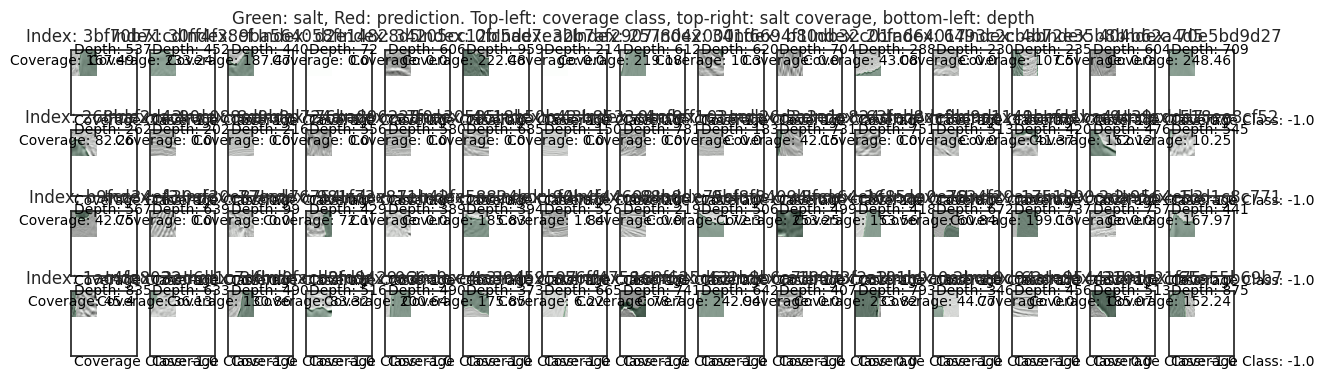

In [56]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx, 'images']  # Assuming 'images' is the column name for images
    mask = train_df.loc[idx, 'masks']   # Assuming 'masks' is the column name for masks
    pred = preds_valid[i]

    if mask is None or pred is None:
        continue  # Skip if mask or pred is None

    # Ensure mask and pred are numpy arrays and convert to float32 if necessary
    mask = mask.astype(np.float32)
    pred = pred.astype(np.float32)

    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")

    # Example text positions, adjust as needed
    ax.text(10, 10, f"Depth: {train_df.loc[idx, 'z']}", color="black")
    ax.text(img_size_ori - 10, 10, f"Coverage: {round(train_df.loc[idx, 'coverage'], 2)}", color="black", ha="right", va="top")
    ax.text(10, img_size_ori - 10, f"Coverage Class: {train_df.loc[idx, 'coverage_class']}", color="black", ha="left", va="top")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Index: {idx}")  # Set title as per your requirement

plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
plt.tight_layout()
plt.show()


In [68]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    print("y_true_in shape:", y_true_in.shape)
    print("y_pred_in shape:", y_pred_in.shape)

    # Ensure y_true_in and y_pred_in have the same shape
    if labels.shape != y_pred.shape:
        print("Shape mismatch:", labels.shape, y_pred.shape)
        return 0

    # Handle potential None values in labels
    if labels is None or y_pred is None:
        return 0

    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:, 1:]
    union = union[1:, 1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        # Handle potential None values before calling iou_metric
        if y_true_in[batch] is not None and y_pred_in[batch] is not None:
            value = iou_metric(y_true_in[batch], y_pred_in[batch])
            metric.append(value)
    return np.mean(metric)



thresholds = np.linspace(0, 1, 50)

print("Validation set length:", len(y_valid_ori))
print("Predictions set length:", len(preds_valid))

# Calculate IoU for each threshold
ious = np.array([iou_metric_batch(y_valid_ori, (preds_valid > threshold).astype(int)) for threshold in tqdm(thresholds)])

print("IoU scores:", ious)


Validation set length: 800
Predictions set length: 800


  0%|          | 0/50 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
y_pred_in shape: (256, 256)
Shape mismatch: (101, 101) (256, 256)
y_true_in shape: (101, 101)
y_pred_in shape: (256, 256)
Shape mismatch: (101, 101) (256, 256)
y_true_in shape: (101, 101)
y_pred_in shape: (256, 256)
Shape mismatch: (101, 101) (256, 256)
y_true_in shape: (101, 101)
y_pred_in shape: (256, 256)
Shape mismatch: (101, 101) (256, 256)
y_true_in shape: (101, 101)
y_pred_in shape: (256, 256)
Shape mismatch: (101, 101) (256, 256)
y_true_in shape: (101, 101)
y_pred_in shape: (256, 256)
Shape mismatch: (101, 101) (256, 256)
y_true_in shape: (101, 101)
y_pred_in shape: (256, 256)
Shape mismatch: (101, 101) (256, 256)
y_true_in shape: (101, 101)
y_pred_in shape: (256, 256)
Shape mismatch: (101, 101) (256, 256)
y_true_in shape: (101, 101)
y_pred_in shape: (256, 256)
Shape mismatch: (101, 101) (256, 256)
y_true_in shape: (101, 101)
y_pred_in shape: (256, 256)
Shape mismatch: (101, 101) (256, 256)
y_true_in shape: (101, 101)
y_pred_in

In [69]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

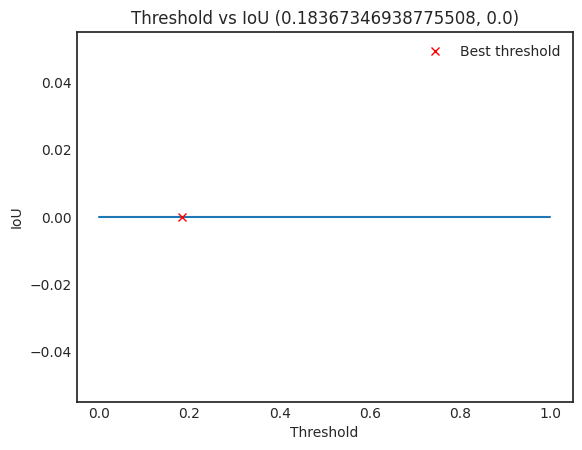

In [70]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

## Problem Two: Code reading

**Visualized Scaling Steps:**

I reviewed the scaling methods to ensure they behave as expected. These checks help confirm their reliability and make them suitable for reuse by others.

**Stratification by Salt Content:**

I stratified the data based on different salt levels in the images. This improved the data handling process, leading to better model training results.

**Y-Axis Image Flipping Augmentation:**

I implemented image augmentation by flipping images horizontally along the y-axis. This technique was verified and refined through discussions in forums.

**Integration of Dropout for Enhanced Performance:**

I added dropout regularization to the model architecture. This resulted in noticeable performance improvements during testing and validation.